In [1]:
# pip install transformers datasets

     ---------------------------------------- 0.0/44.1 kB ? eta -:--:--
     -------------------------- ----------- 30.7/44.1 kB 640.0 kB/s eta 0:00:01
     ----------------------------------- -- 41.0/44.1 kB 653.6 kB/s eta 0:00:01
     -------------------------------------- 44.1/44.1 kB 360.6 kB/s eta 0:00:00
     ---------------------------------------- 0.0/41.5 kB ? eta -:--:--
     ---------------------------------------- 41.5/41.5 kB 2.1 MB/s eta 0:00:00
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ----------------------------------- ---- 51.2/57.6 kB 2.6 MB/s eta 0:00:01
     -------------------------------------- 57.6/57.6 kB 764.4 kB/s eta 0:00:00
     ---------------------------------------- 0.0/69.9 kB ? eta -:--:--
     ----- ---------------------------------- 10.2/69.9 kB ? eta -:--:--
     ---------------- --------------------- 30.7/69.9 kB 640.0 kB/s eta 0:00:01
     --------------------------------- ---- 61.4/69.9 kB 544.7 kB/s eta 0:00:01


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
from datasets import load_dataset
dataset = load_dataset("cnn_dailymail", "3.0.0")

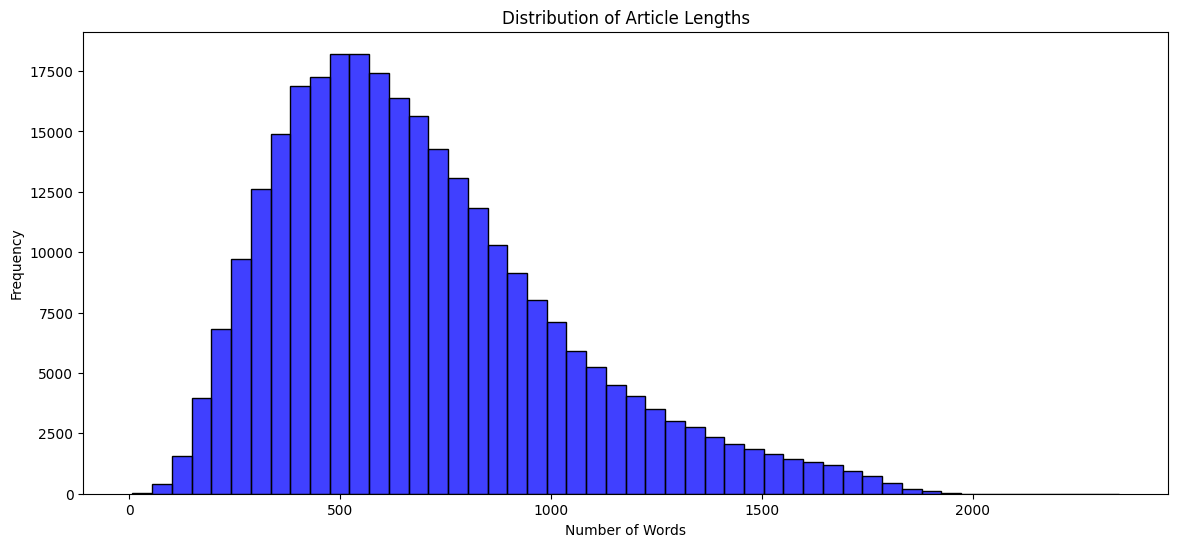

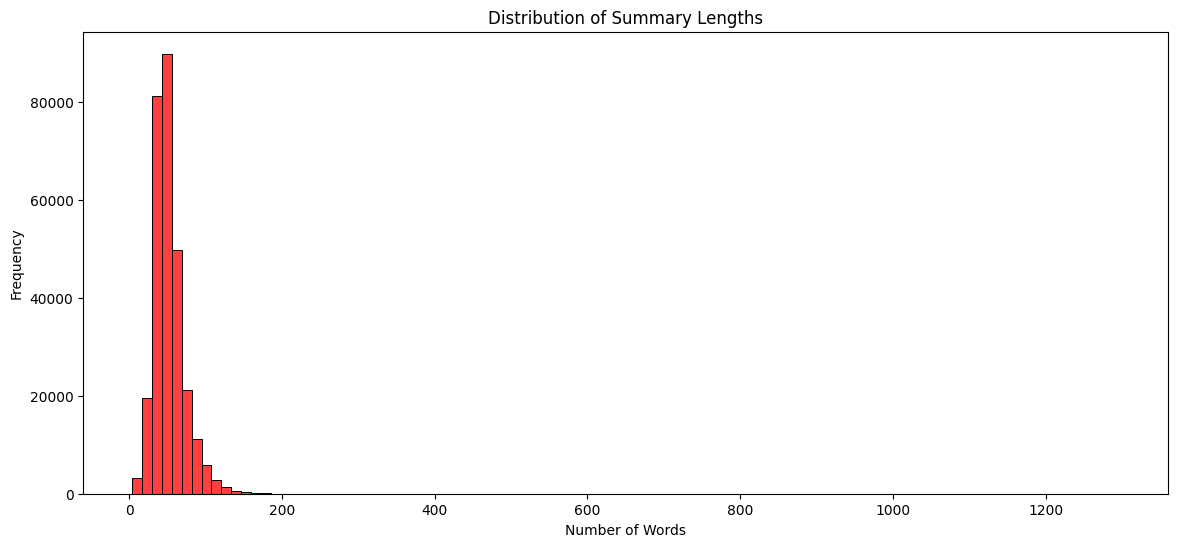

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns


# Compute lengths
article_lengths = [len(article.split()) for article in dataset['train']['article']]
summary_lengths = [len(summary.split()) for summary in dataset['train']['highlights']]

# Plotting Article Lengths
plt.figure(figsize=(14, 6))
sns.histplot(article_lengths, bins=50, color='blue')
plt.title('Distribution of Article Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

# Plotting Summary Lengths
plt.figure(figsize=(14, 6))
sns.histplot(summary_lengths, bins=100, color='red')
plt.title('Distribution of Summary Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

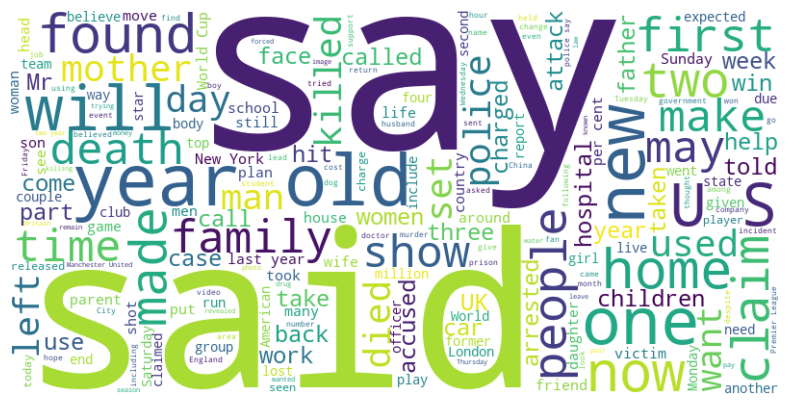

In [5]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Join all summaries
text = " ".join(summary for summary in dataset['train']['highlights'])

# Optionally, you can clean the text (remove stopwords, punctuation, etc.)
# For example:
# text = clean_text_function(text)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Plot the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Disable axis
plt.show()


In [ ]:
from transformers import BartTokenizer, BartForConditionalGeneration

tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')

In [16]:
def preprocess_function(examples):
    # Tokenize articles and highlights
    inputs = tokenizer(examples['article'], padding='max_length', truncation=True, max_length=1024)  # Adjusted max_length
    labels = tokenizer(examples['highlights'], padding='max_length', truncation=True, max_length=150)  # Adjusted max_length

    # Ensure that labels are padded to the same length as inputs
    inputs['labels'] = labels['input_ids']
    return inputs

# Apply the preprocessing function to the dataset
tokenized_datasets = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/287113 [00:00<?, ? examples/s]

Map:   0%|          | 0/13368 [00:00<?, ? examples/s]

Map:   0%|          | 0/11490 [00:00<?, ? examples/s]

In [19]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f"Using device: {device}")

Using device: cpu


In [23]:
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

device = torch.device(device)

In [24]:
print(device)

cpu


In [26]:
import torch
print(torch.cuda.is_available())

False


In [25]:
from transformers import Trainer, TrainingArguments


# Define training arguments
training_args = TrainingArguments(  
    output_dir='./results',          
    num_train_epochs=3,              
    per_device_train_batch_size=4,  
    per_device_eval_batch_size=4,   
    warmup_steps=500,                
    weight_decay=0.01,               
    logging_dir='./logs',
    report_to="none",
    remove_unused_columns=False,
)

# Initialize Trainer
trainer = Trainer(
    model=model.to('cuda:0'),
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
)

AssertionError: Torch not compiled with CUDA enabled

In [ ]:
# Start training
trainer.train()

In [32]:
print(model.config.vocab_size)


50264


In [34]:

# Tokenize a sample input
inputs = tokenizer("Hello, how are you?", return_tensors="pt")
print("Input IDs:", inputs['input_ids'])

# Check token IDs range
vocab_size = tokenizer.vocab_size
print("Vocab Size:", vocab_size)
if (inputs['input_ids'] >= vocab_size).any():
    raise ValueError("Some token IDs are out of range")

Input IDs: tensor([[    0, 31414,     6,   141,    32,    47,   116,     2]])
Vocab Size: 50265
